## Unsupervised learning

In [5]:
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, silhouette_samples
from scipy.spatial.distance import cdist, pdist
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.cluster import hierarchy
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import StandardScaler, MinMaxScaler


### Exemplos de informações calculadas manualmente em uma base pequena

In [6]:
df = {
    'x1': [1.0,1.5,3.0,5.0,3.5,4.5,3.5],
    'x2': [1.0,2.0,4.0,7.0,5.0,5.0,4.5]
}
df=pd.DataFrame(df)
df

,x1,x2
0,1.0,1.0
1,1.5,2.0
2,3.0,4.0
3,5.0,7.0
4,3.5,5.0
5,4.5,5.0
6,3.5,4.5


#### Ajuste do modelo com algumas informações prontas

In [7]:
n_clusters = 3
clf = KMeans(n_clusters , init = np.array([[1.0, 1.0], [5.0,7.0],[2,3]], np.float64), n_init = 1)

clf.fit(df)
clusters_labels = clf.predict(df)
print 'Centroides: ', clf.cluster_centers_
print '\nInertia ou WCSS: ', clf.inertia_
print '\nClusters preditos: ' ,clusters_labels

Centroides:  [[ 1.25        1.5       ]
 [ 4.75        6.        ]
 [ 3.33333333  4.5       ]]

Inertia ou WCSS:  3.41666666667

Clusters preditos:  [0 0 2 1 2 1 2]


#### Cálculo centroides na mão

In [8]:
df_total = pd.concat([df, pd.DataFrame(clusters_labels, columns = ['label'])], axis = 1)
centroides_m = df_total.groupby(by = ['label']).mean()
print centroides_m
print '\n'
print df_total

             x1   x2
label               
0      1.250000  1.5
1      4.750000  6.0
2      3.333333  4.5


    x1   x2  label
0  1.0  1.0      0
1  1.5  2.0      0
2  3.0  4.0      2
3  5.0  7.0      1
4  3.5  5.0      2
5  4.5  5.0      1
6  3.5  4.5      2


#### cálculo inertia ou wmcc na mão

In [9]:
a = []
first=True
for k in range(n_clusters):
    df_total2 = df_total[df_total.label == k]
    aux = euclidean_distances(df_total2.iloc[:,0:(df_total2.shape[1]-1)], centroides_m[centroides_m.index == k])**2
    aux = pd.DataFrame(aux)
    print 'wcss no cluster k =', k , ':', aux.sum()
    #print 'average distance from centroide in cluster k =', k , ':', aux.mean()
    #print 'maximum distance from centroide in cluster k =', k , ':', aux.max()
    if first == True:
        a=pd.DataFrame(aux)
        first = False
    else:
        a = pd.concat([a, aux], axis = 0)
    #print(a)
    #a.append(aux)

wcss_m = np.float(a.sum())
print '\nWCSS:', wcss_m

wcss no cluster k = 0 : 0    0.625
dtype: float64
wcss no cluster k = 1 : 0    2.125
dtype: float64
wcss no cluster k = 2 : 0    0.666667
dtype: float64

WCSS: 3.41666666667


#### silhueta

In [10]:
silhueta = silhouette_score(df,  clusters_labels)
silhueta

0.46046600146599725

#### total sum-of-squares

In [11]:
media_geral = df.mean()
media_geral = media_geral.values.reshape(1,-1)
media_geral
tss = euclidean_distances(df, media_geral)
tss = pd.DataFrame(tss)
tss_m = np.float(tss.sum())
tss_m
bcss_m = tss_m - wcss_m
print 'TSS:', tss_m
print 'BCSS:', bcss_m

TSS: 13.2135569382
BCSS: 9.79689027155


#### calcular distâncias minima e máxima entre pontos de clusters diferentes

In [12]:
df_total

,x1,x2,label
0,1.0,1.0,0
1,1.5,2.0,0
2,3.0,4.0,2
3,5.0,7.0,1
4,3.5,5.0,2
5,4.5,5.0,1
6,3.5,4.5,2


In [22]:
df0 = df_total[df_total.label==0].iloc[:,0:2]
df1 = df_total[df_total.label==1].iloc[:,0:2]
df2 = df_total[df_total.label==2].iloc[:,0:2]

In [30]:
dpairs_01 = euclidean_distances(df0,df1)
dpairs_02 = euclidean_distances(df0,df2)
dpairs_12 = euclidean_distances(df1,df2)

#### ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#### ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [13]:
def information_data (data):
       
    len_array = []
    for var in data.columns:
        current_len  = len(data[var].unique())
        len_array.append(current_len)

    missing = pd.DataFrame(np.array(data.isnull().sum()), columns = ['missing'])
    p_missing = missing / data.shape[0]
    types = pd.DataFrame( np.array(data.dtypes), columns=['type'])

    qtd = pd.concat([pd.DataFrame(data.columns), types.type, missing.missing, pd.DataFrame(p_missing),  pd.DataFrame(len_array)], axis = 1)
    qtd.columns = ['var', 'type', '# missing','% missing', '# unique values']
    
    print 'Data with', data.shape[0], 'samples and ', data.shape[1], 'features'
    print '\n'
    print 'Data with', qtd[qtd['# missing'] > 0].shape[0], 'columns with missings'
    print '\n'
    
    return qtd

def fit_transform_with_function (data, function, sklearn):
    scaler = function
    
    if sklearn == 'True':
        scaler = function
        data_transformed = scaler.fit_transform(data)
        data_transformed2 = pd.DataFrame(data_transformed, columns = data.columns, index = data.index)
        
    else:
        data_transformed2 = data.apply(function)
        
    return scaler, data_transformed2

#X_train.apply(standard_scaler_manual)


def transform_with_function (data, scaler, sklearn):
    
    if sklearn == 'True':
        data_transformed = scaler.transform(data)
        data_transformed2 = pd.DataFrame(data_transformed, columns = data.columns, index = data.index)
    
    else:
        data_transformed2 = data.apply(scaler)
    
        
    
    return data_transformed2

## 1. Aplicação em uma base
### medidas automáticas saída do sklearn, gráfico elbow, função para testar diferentes k's com silhueta e elbow para avaliação

In [24]:
data = pd.read_csv('data_cluster.csv', sep=';', decimal = ',')
data.head()

,y,x1,x2,x3,x4,x5,x6,x7,x8,x9
1,3,-0.560475646552213,-0.995798724851333,-0.511603722189581,-0.150307477864079,0.19654977656002,1,0,0,0
2,3,-0.23017748948328,-1.03995504376619,0.236937879127631,-0.327757132786462,0.650113188667264,1,0,0,0
3,2,1.55870831414912,-0.0179802405766626,-0.541589171621698,-1.44816529018399,0.671004187901994,0,0,1,0
4,3,0.070508391424576,-0.132175132856735,1.21922764704307,-0.697284584551622,-1.28415776513223,1,1,1,0
5,3,0.129287735160946,-2.54934277475043,0.174135875106149,2.59849023212988,-2.02610958278953,1,0,0,1


In [25]:
information_data(data)

Data with 1000 samples and  10 features


Data with 0 columns with missings




,var,type,# missing,% missing,# unique values
0,y,int64,0,0.0,3
1,x1,object,0,0.0,1000
2,x2,object,0,0.0,1000
3,x3,object,0,0.0,1000
4,x4,object,0,0.0,1000
5,x5,object,0,0.0,1000
6,x6,int64,0,0.0,2
7,x7,int64,0,0.0,2
8,x8,int64,0,0.0,2
9,x9,int64,0,0.0,2


### K-MEANS

In [26]:
data2 = data.drop(['y'], axis = 1)


In [27]:
X = data2.iloc[0:900,:]
X_pred = data2.iloc[900:1000,:]
Y = data.iloc[0:900, 0]
Y_pred = data.iloc[900:1000, 0]

In [28]:
Y_pred.shape

(100L,)

In [29]:
array_init = np.array([[-0.04,2,0.4,0.02,0.04,0.3,0.05,0.04,0.9],
              [0.04,2,0.4,1,0.04,0.03,0.05,0.04,0.19],
              [-0.4,2,4,0.02,0.04,0.33,0.15,0.24,0.39]], np.float64)

In [42]:
n_clusters=3
kmeans = KMeans(n_clusters=3, random_state=10,init = 'k-means++', max_iter=300,verbose=0)
#escolhendo pontos iniciais
#kmeans = KMeans(n_clusters=3, random_state=10, init = array_init, n_init = 1)

In [43]:
cluster_labels = kmeans.fit_predict(X)
centers = kmeans.cluster_centers_ 
inertia = kmeans.inertia_
inertia

3902.2640493890949

In [44]:
silhueta = silhouette_score(X, cluster_labels)
silhueta

0.11086715677595291

In [45]:
pred_cluster = kmeans.predict(X_pred)
pred_cluster

array([0, 2, 0, 0, 2, 1, 0, 1, 2, 2, 0, 1, 0, 1, 2, 0, 0, 1, 2, 0, 1, 0, 1,
       0, 1, 0, 1, 1, 2, 2, 1, 0, 2, 1, 2, 2, 1, 0, 2, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 1, 2, 1, 0, 1, 2, 2, 1, 0, 1, 0, 0, 0, 2, 2, 2, 1, 1,
       2, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 2, 0, 1, 1, 2, 1, 2, 0, 1, 0, 2, 0,
       2, 1, 2, 2, 0, 1, 0, 1])

### Elbow Method

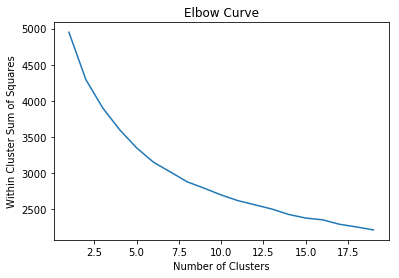

In [46]:
Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans

score = [kmeans[i].fit(X).inertia_ for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Within Cluster Sum of Squares')
plt.title('Elbow Curve')
plt.show()

#### Função para testar varios k diferentes

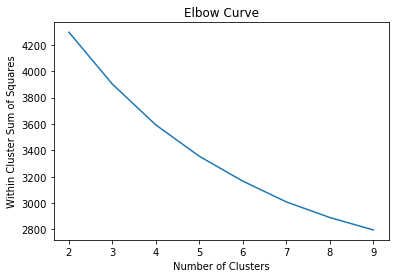

,score_wss,silhueta
2,4295.1,0.1245
3,3901.5,0.1129
4,3592.2,0.1127
5,3354.5,0.1168
6,3166.2,0.1164
7,3008.9,0.1173
8,2890.3,0.1148
9,2796.4,0.1130


In [47]:
k_values = range(2,10)
first=True
for k in k_values:
    kmeans = KMeans(n_clusters=k)
    cluster_labels = kmeans.fit_predict(X)
    score_wss = round(kmeans.inertia_ ,1)
    silhueta = round(silhouette_score(X, cluster_labels),4)
    #plt.plot(Nc,score)
    #plt.xlabel('Number of Clusters')
    #plt.ylabel('Within Cluster Sum of Squares')
    #plt.title('Elbow Curve')
    #plt.show()
    resultados_aux = {
        'score_wss': score_wss,
        'silhueta': silhueta
    }
    resultados_aux = pd.DataFrame(resultados_aux, index = [k])
    if first == True:
        resultados_final = resultados_aux
        first = False
    else:
        resultados_final = pd.concat([resultados_final, resultados_aux],axis =0)
        

plt.plot(resultados_final.index,resultados_final.score_wss)
plt.xlabel('Number of Clusters')
plt.ylabel('Within Cluster Sum of Squares')
plt.title('Elbow Curve')
plt.show()

resultados_final

## 2. Aplicação
###  Aplicação de transformação dos dados,  aplicação de PCA na base iris - com visualização , 


#### 1. importando a base

In [48]:
from sklearn.datasets import load_iris

In [49]:
iris = load_iris()
data = pd.DataFrame(iris.data)
data.columns = iris.feature_names
data['target']  = iris.target

print information_data(data)
data.head()

Data with 150 samples and  5 features


Data with 0 columns with missings


                 var     type  # missing  % missing  # unique values
0  sepal length (cm)  float64          0        0.0               35
1   sepal width (cm)  float64          0        0.0               23
2  petal length (cm)  float64          0        0.0               43
3   petal width (cm)  float64          0        0.0               22
4             target    int32          0        0.0                3


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [50]:
Y = data.iloc[0:140, 4]
Y_pred = data.iloc[140:150, 4]
data.drop(['target'], axis = 1, inplace=True)
X = data.iloc[0:140, :]
X_pred = data.iloc[140:150, :]


#### 2. padroniza a base

In [51]:
scaler, data_norm = fit_transform_with_function(X, StandardScaler(), 'True')

In [52]:
data_norm.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,-0.841395,1.004906,-1.272127,-1.260189
1,-1.081794,-0.126017,-1.272127,-1.260189
2,-1.322193,0.326352,-1.328756,-1.260189
3,-1.442392,0.100167,-1.215498,-1.260189
4,-0.961595,1.231090,-1.272127,-1.260189


#### 3. aplica PCA

In [53]:
pca = PCA(n_components=2)
pc = pca.fit_transform(data_norm)

data_norm_pca = pd.DataFrame(data = pc, columns = ['PC 1', 'PC 2'])
data_norm_pca_target = pd.concat([data_norm_pca, Y], axis = 1)
data_norm_target = pd.concat([data_norm, Y], axis = 1)

print "Percentual da variância explicada:", pca.explained_variance_ratio_ 
data_norm_pca_target.head()

Percentual da variância explicada: [ 0.73247348  0.22759498]


,PC 1,PC 2,target
0,-2.163730,0.477686,0
1,-1.974200,-0.653524,0
2,-2.256933,-0.335834,0
3,-2.190676,-0.587235,0
4,-2.288683,0.637372,0


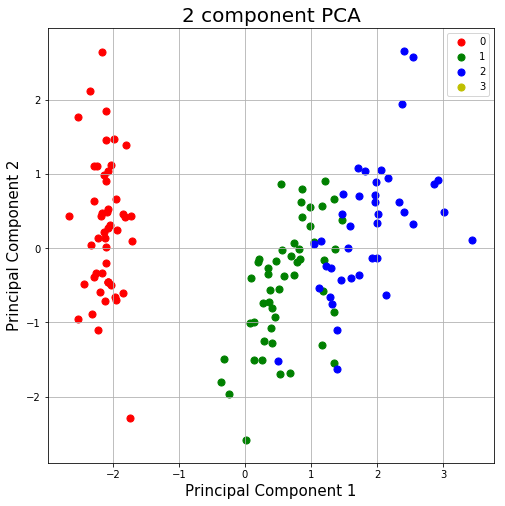

In [54]:
def plot_PCA_groups (data, group):
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title('2 component PCA', fontsize = 20)
    #targets = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']

    targets = [0 ,1 ,2, 3]
    colors = ['r', 'g', 'b', 'y']
    for target, color in zip(targets,colors):
        indicesToKeep = data[group] == target
        ax.scatter(data.loc[indicesToKeep, 'PC 1']
                   , data.loc[indicesToKeep, 'PC 2']
                   , c = color
                   , s = 50)
    ax.legend(targets)
    ax.grid()
    return fig

plot_PCA_groups(data_norm_pca_target, 'target')

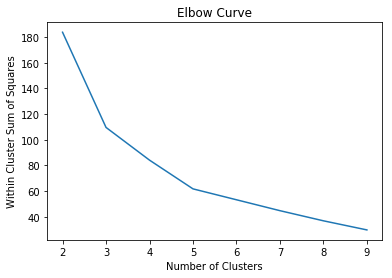

,score_wss,silhueta
2,183.8,0.6124
3,109.6,0.5053
4,84.1,0.4406
5,61.7,0.4161
6,53.2,0.4294
7,44.7,0.4251
8,36.8,0.4359
9,29.7,0.4412


In [56]:
base = data_norm_pca
k_values = range(2,10)
first=True
for k in k_values:
    kmeans = KMeans(n_clusters=k)
    cluster_labels = kmeans.fit_predict(base)
    score_wss = round(kmeans.inertia_ ,1)
    silhueta = round(silhouette_score(base, cluster_labels),4)
    resultados_aux = {
        'score_wss': score_wss,
        'silhueta': silhueta
    }
    resultados_aux = pd.DataFrame(resultados_aux, index = [k])
    if first == True:
        resultados_final = resultados_aux
        first = False
    else:
        resultados_final = pd.concat([resultados_final, resultados_aux],axis =0)
        

plt.plot(resultados_final.index,resultados_final.score_wss)
plt.xlabel('Number of Clusters')
plt.ylabel('Within Cluster Sum of Squares')
plt.title('Elbow Curve')
plt.show()

resultados_final

#### 4. Ajuste da função - versão com e sem pca

In [58]:
kmeans_pca = KMeans(n_clusters=3)
kmeans_sempca = KMeans(n_clusters=3)

kmeans_sempca.fit(data_norm)
kmeans_pca.fit(data_norm_pca)

cluster_labels_sempca = kmeans_sempca.predict(data_norm)
cluster_labels_compca = kmeans_pca.predict(data_norm_pca)

#cluster_labels_compca = kmeans_compca.predict(pcDf)

In [61]:
# tabela fim
previsoes = pd.concat([data_norm_pca_target, pd.DataFrame(cluster_labels_sempca), pd.DataFrame(cluster_labels_compca)], axis = 1)
previsoes.columns = ['PC 1', 'PC 2', 'target', 'prev_sempca', 'prev_compca']
previsoes
#pd.crosstab(previsoes.target, previsoes.prev_sempca)

,PC 1,PC 2,target,prev_sempca,prev_compca
0,-2.163730,0.477686,0,1,1
1,-1.974200,-0.653524,0,1,1
2,-2.256933,-0.335834,0,1,1
3,-2.190676,-0.587235,0,1,1
4,-2.288683,0.637372,0,1,1
5,-1.976561,1.469842,0,1,1
6,-2.335202,0.040553,0,1,1
7,-2.130301,0.224603,0,1,1
8,-2.222303,-1.098450,0,1,1
9,-2.080779,-0.452408,0,1,1


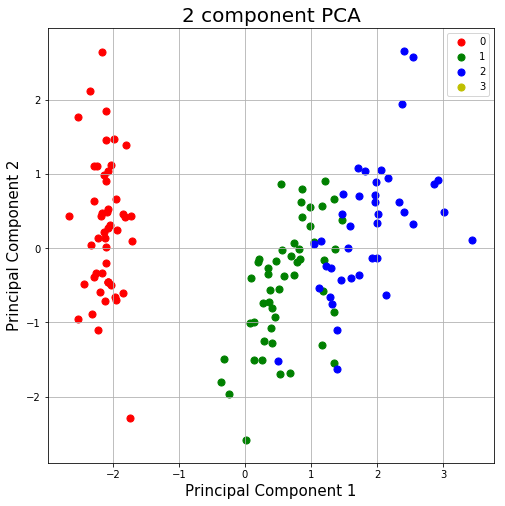

In [62]:
plot_PCA_groups(previsoes, 'target')

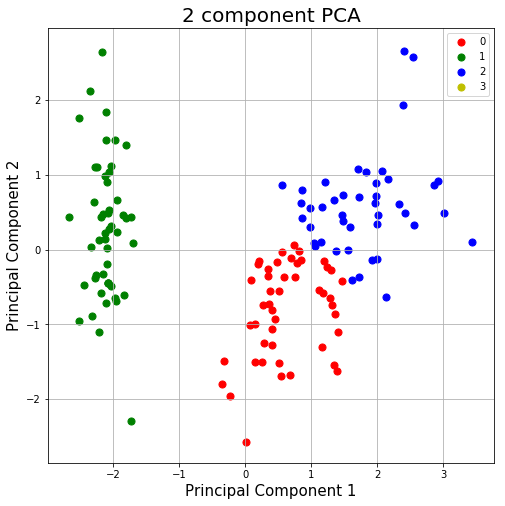

In [63]:
plot_PCA_groups(previsoes, 'prev_compca')

#### 5. Centroides, wcss, silhueta - exemplo do caso da base pca

In [74]:
kmeans_pca.cluster_centers_

array([[ 0.61951403, -0.81619117],
       [-2.11597109,  0.26757859],
       [ 1.78328826,  0.58097803]])

In [73]:
df_total = pd.concat([data_norm_pca, pd.DataFrame(cluster_labels_compca, columns = ['label'])], axis = 1)
centroides_m = df_total.groupby(by = ['label']).mean()
print centroides_m
df_total.head()

           PC 1      PC 2
label                    
0      0.619514 -0.816191
1     -2.115971  0.267579
2      1.783288  0.580978


,PC 1,PC 2,label
0,-2.163730,0.477686,1
1,-1.974200,-0.653524,1
2,-2.256933,-0.335834,1
3,-2.190676,-0.587235,1
4,-2.288683,0.637372,1


In [76]:
a = []
first=True
for k in range(n_clusters):
    df_total2 = df_total[df_total.label == k]
    aux = euclidean_distances(df_total2.iloc[:,0:(df_total2.shape[1]-1)], centroides_m[centroides_m.index == k])**2
    aux = pd.DataFrame(aux)
    print 'wcss no cluster k =', k , ':', aux.sum()
    #print 'average distance from centroide in cluster k =', k , ':', aux.mean()
    #print 'maximum distance from centroide in cluster k =', k , ':', aux.max()
    if first == True:
        a=pd.DataFrame(aux)
        first = False
    else:
        a = pd.concat([a, aux], axis = 0)
    #print(a)
    #a.append(aux)

wcss_m = np.float(a.sum())
print '\nWCSS:', wcss_m

wcss no cluster k = 0 : 0    29.457493
dtype: float64
wcss no cluster k = 1 : 0    43.875071
dtype: float64
wcss no cluster k = 2 : 0    36.251732
dtype: float64

WCSS: 109.584296433


#### Predição para os casos de PCA

usar scaler 

In [64]:
new_data_pred = transform_with_function(X_pred, scaler, 'True')

In [65]:
pred_clusters_extra = pca.transform(new_data_pred)
pred_clusters_extra

array([[ 2.14687477,  0.65151938],
       [ 2.03045287,  0.7303947 ],
       [ 1.29109863, -0.65261902],
       [ 2.16812842,  0.90354015],
       [ 2.13078156,  1.0754462 ],
       [ 2.00170601,  0.42977119],
       [ 1.69470269, -0.83105335],
       [ 1.64746037,  0.31131373],
       [ 1.50537747,  1.02433985],
       [ 1.08831383,  0.00880632]])

In [66]:
pcDf_pred = pd.DataFrame(data = pred_clusters_extra, columns = ['PC 1', 'PC 2'])

In [67]:
clusteres_pred = kmeans_pca.predict(pcDf_pred)
clusteres_pred

array([2, 2, 0, 2, 2, 2, 0, 2, 2, 2])

In [69]:
pred_total = pd.concat([pcDf_pred, pd.DataFrame(Y_pred).reset_index(drop=True), pd.DataFrame (clusteres_pred, columns=['pred'])], axis = 1)
pred_total

,PC 1,PC 2,target,pred
0,2.146875,0.651519,2,2
1,2.030453,0.730395,2,2
2,1.291099,-0.652619,2,0
3,2.168128,0.903540,2,2
4,2.130782,1.075446,2,2
5,2.001706,0.429771,2,2
6,1.694703,-0.831053,2,0
7,1.647460,0.311314,2,2
8,1.505377,1.024340,2,2
9,1.088314,0.008806,2,2
